# Task 7: Text Network Analysis and Visualization on Agriculture Dataset

This notebook constructs a text corpus from categorical fields in `agriculture_crop_yield.csv` and generates:
- Word cloud / tag cloud
- Word co-occurrence network with community detection
- WordTree (Google Charts)
- Exportable corpus for InfraNodus

It also summarizes insights from the analysis.


In [1]:
import os
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import itertools
import re

# Paths
DATA_PATH = "/Users/karthikmac/Downloads/DV_USECASE/task 7/agriculture_crop_yield.csv"
OUTPUT_DIR = "/Users/karthikmac/Downloads/DV_USECASE/task 7/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load
df = pd.read_csv(DATA_PATH)
df.head()


,Year,State,Crop_Type,Area_Hectares,Yield_Tonnes,Yield_per_Hectare,Season,Climate_Zone,Soil_Type,Irrigation_Type,Fertilizer_Usage_kg,Precipitation_mm,Temperature_Celsius,Pest_Infestation_Level,Disease_Incidence,Harvest_Date,Storage_Loss_Percentage,Market_Price_per_Tonne,Total_Revenue
0,2020,California,Corn,125000,875000,7.0,Summer,Mediterranean,Clay Loam,Drip Irrigation,250,450,28.5,Low,Low,2020-09-15,2.5,180,157500000
1,2020,California,Wheat,85000,340000,4.0,Winter,Mediterranean,Sandy Loam,Sprinkler,180,380,22.0,Medium,Low,2020-06-20,1.8,220,74800000
2,2020,California,Soybeans,95000,285000,3.0,Summer,Mediterranean,Clay Loam,Drip Irrigation,200,420,26.0,Low,Medium,2020-10-10,2.0,350,99750000
3,2020,Texas,Corn,180000,1080000,6.0,Summer,Subtropical,Clay,Flood Irrigation,220,600,32.0,High,Medium,2020-09-20,3.2,175,189000000
4,2020,Texas,Cotton,120000,360000,3.0,Summer,Subtropical,Sandy,Flood Irrigation,150,550,30.5,Medium,High,2020-10-05,1.5,280,100800000


In [2]:
# Build per-row text corpus from categorical/nominal fields
text_fields = [
    "State","Crop_Type","Season","Climate_Zone","Soil_Type","Irrigation_Type",
    # Discretize some numeric or ordinal fields into tokens as well
    "Pest_Infestation_Level","Disease_Incidence"
]

# Helper: normalize tokens
stopwords = set("""a an the and or of in on for to with by from at as is are was were be been being low medium high summer winter continental subtropical mediterranean""".split())

word_pattern = re.compile(r"[a-zA-Z][a-zA-Z\-]+")

def normalize(text: str):
    tokens = [t.lower() for t in word_pattern.findall(str(text))]
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

row_texts = []
for _, row in df.iterrows():
    parts = []
    for col in text_fields:
        val = row.get(col, "")
        if pd.isna(val):
            continue
        parts.append(str(val))
    # Add discretized bins for precipitation and temperature
    precip = row.get("Precipitation_mm", np.nan)
    temp = row.get("Temperature_Celsius", np.nan)
    fert = row.get("Fertilizer_Usage_kg", np.nan)
    if not pd.isna(precip):
        precip_bin = pd.qcut(df["Precipitation_mm"], 3, labels=["precip_low","precip_med","precip_high"]).astype(str)[_]
        parts.append(precip_bin)
    if not pd.isna(temp):
        temp_bin = pd.qcut(df["Temperature_Celsius"], 3, labels=["temp_low","temp_med","temp_high"]).astype(str)[_]
        parts.append(temp_bin)
    if not pd.isna(fert):
        fert_bin = pd.qcut(df["Fertilizer_Usage_kg"], 3, labels=["fert_low","fert_med","fert_high"]).astype(str)[_]
        parts.append(fert_bin)

    text = " ".join(parts)
    tokens = normalize(text)
    row_texts.append(tokens)

# Flatten for global counts
all_tokens = list(itertools.chain.from_iterable(row_texts))

# Save corpus lines (space-joined tokens per row)
corpus_lines = [" ".join(toks) for toks in row_texts]
corpus_path = os.path.join(OUTPUT_DIR, "corpus.txt")
with open(corpus_path, "w") as f:
    f.write("\n".join(corpus_lines))

len(row_texts), len(all_tokens), corpus_path


(86, 811, '/Users/karthikmac/Downloads/DV_USECASE/task 7/outputs/corpus.txt')

In [3]:
# Word frequencies (tag cloud data)
freq = Counter(all_tokens)

freq_df = pd.DataFrame(freq.most_common(), columns=["token","count"])
freq_csv = os.path.join(OUTPUT_DIR, "tag_frequencies.csv")
freq_df.to_csv(freq_csv, index=False)
freq_df.head(20)


,token,count
0,precip,86
1,temp,86
2,fert,86
3,med,85
4,irrigation,84
5,flood,80
6,clay,54
7,loam,54
8,corn,34
9,soybeans,28


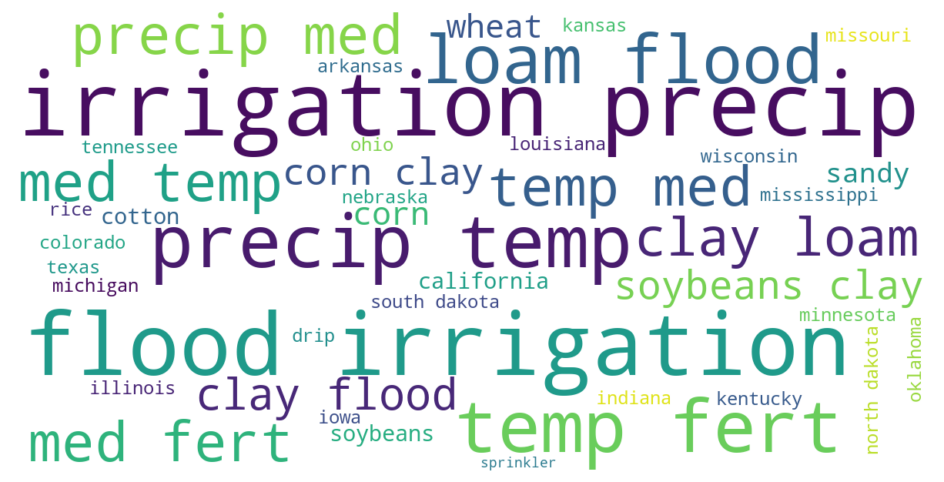

In [4]:
# Word cloud visualization (static)
try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    text_for_wc = " ".join(all_tokens)
    wc = WordCloud(width=1200, height=600, background_color="white").generate(text_for_wc)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    wc_path = os.path.join(OUTPUT_DIR, "wordcloud.png")
    plt.savefig(wc_path, bbox_inches="tight")
    wc_path
except Exception as e:
    print("WordCloud not available:", e)
    None


In [5]:
# Build co-occurrence network
# Undirected edges for tokens co-present within a row (sliding window not necessary here due to tokens being categorical)

min_token_freq = 3  # prune very rare tokens
filtered_tokens_per_row = []
valid_tokens = {t for t,c in freq.items() if c >= min_token_freq}
for toks in row_texts:
    toks = [t for t in toks if t in valid_tokens]
    filtered_tokens_per_row.append(sorted(set(toks)))

edge_weights = Counter()
for toks in filtered_tokens_per_row:
    for a, b in itertools.combinations(toks, 2):
        if a == b:
            continue
        if a > b:
            a, b = b, a
        edge_weights[(a,b)] += 1

# Create graph and detect communities
import networkx as nx
G = nx.Graph()
for (a,b), w in edge_weights.items():
    G.add_edge(a, b, weight=int(w))

# Remove isolates that have no edges
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

# Community detection (Louvain if available, else greedy modularity)
community_labels = {}
try:
    import community as community_louvain  # python-louvain
    partition = community_louvain.best_partition(G, weight='weight')
    community_labels = partition
except Exception:
    communities = nx.algorithms.community.greedy_modularity_communities(G, weight='weight')
    for idx, comm in enumerate(communities):
        for node in comm:
            community_labels[node] = idx

# Export nodes/edges for Gephi/Cytoscape
nodes_export = os.path.join(OUTPUT_DIR, "network_nodes.csv")
edges_export = os.path.join(OUTPUT_DIR, "network_edges.csv")

nodes_rows = []
for n in G.nodes():
    nodes_rows.append({
        "id": n,
        "label": n,
        "degree": int(G.degree(n)),
        "freq": int(freq[n]),
        "community": int(community_labels.get(n, -1))
    })

edges_rows = []
for a, b, data in G.edges(data=True):
    edges_rows.append({
        "source": a,
        "target": b,
        "weight": int(data.get("weight", 1))
    })

pd.DataFrame(nodes_rows).to_csv(nodes_export, index=False)
pd.DataFrame(edges_rows).to_csv(edges_export, index=False)

len(G), G.number_of_edges(), nodes_export, edges_export


(37,
 290,
 '/Users/karthikmac/Downloads/DV_USECASE/task 7/outputs/network_nodes.csv',
 '/Users/karthikmac/Downloads/DV_USECASE/task 7/outputs/network_edges.csv')

'/Users/karthikmac/Downloads/DV_USECASE/task 7/outputs/network.png'

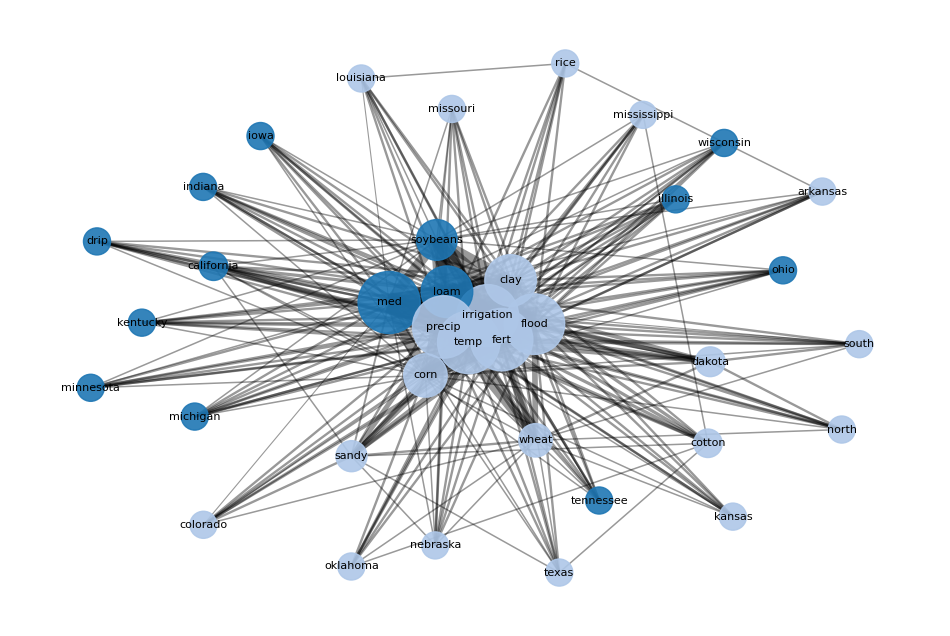

In [6]:
# Quick network visualization (spring layout)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=42, k=0.3)

# Color by community
communities = [community_labels.get(n, -1) for n in G.nodes()]
unique_comms = sorted(set(communities))
comm_to_color = {c: plt.cm.tab20(i % 20) for i,c in enumerate(unique_comms)}
node_colors = [comm_to_color[c] for c in communities]

sizes = [300 + 20*freq[n] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=[0.5 + 0.3*data['weight'] for _,_,data in G.edges(data=True)], alpha=0.4)
labels = {n: n for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)
plt.axis('off')
net_img = os.path.join(OUTPUT_DIR, "network.png")
plt.savefig(net_img, dpi=200, bbox_inches='tight')
net_img


In [7]:
# WordTree data preparation (simple phrase expansions)
# We'll build parent->children expansions based on bigrams from corpus_lines

bigram_counts = Counter()
for line in corpus_lines:
    toks = line.split()
    bigram_counts.update(zip(toks, toks[1:]))

# Choose a root term to explore in WordTree (most frequent token)
root_token = freq_df.iloc[0]['token'] if not freq_df.empty else None
root_token


'precip'

In [8]:
# Create a basic WordTree HTML using Google Charts
from html import escape

if root_token:
    # Build paths from root for a limited depth
    depth_limit = 3
    paths = []
    for line in corpus_lines:
        toks = line.split()
        for i, t in enumerate(toks):
            if t == root_token:
                phrase = [t]
                j = i + 1
                while j < len(toks) and len(phrase) < depth_limit+1:
                    phrase.append(toks[j])
                    j += 1
                paths.append(" ".join(phrase))

    html_path = os.path.join(OUTPUT_DIR, "wordtree.html")
    with open(html_path, "w") as f:
        f.write("""
<!doctype html>
<html>
  <head>
    <meta charset='utf-8'>
    <title>WordTree</title>
    <script type='text/javascript' src='https://www.gstatic.com/charts/loader.js'></script>
    <script type='text/javascript'>
      google.charts.load('current', {packages:['wordtree']});
      google.charts.setOnLoadCallback(drawChart);
      function drawChart() {
        var data = google.visualization.arrayToDataTable([
          ['Phrases'],
"""
        )
        for p in paths:
            f.write("          ['" + escape(p) + "'],\n")
        f.write("""
        ]);
        var options = {
          wordtree: {
            format: 'implicit',
            word: '""" + escape(root_token) + """'
          }
        };
        var chart = new google.visualization.WordTree(document.getElementById('wordtree'));
        chart.draw(data, options);
      }
    </script>
  </head>
  <body>
    <div id='wordtree' style='width: 100%; height: 700px;'></div>
  </body>
</html>
""")
    html_path
else:
    None


In [9]:
# Export for InfraNodus: a plain text file with each line as a document
infra_path = os.path.join(OUTPUT_DIR, "infranodus_corpus.txt")
with open(infra_path, "w") as f:
    for line in corpus_lines:
        f.write(line + "\n")
infra_path


'/Users/karthikmac/Downloads/DV_USECASE/task 7/outputs/infranodus_corpus.txt'